# ***Kütüphane Kurulum***

In [1]:
!pip install tensorflow==2.16.1 -q


In [2]:
import numpy as np  # Numpy kütüphanesini içe aktar
import pandas as pd  # Pandas kütüphanesini içe aktar
import matplotlib.pyplot as plt  # Matplotlib kütüphanesini içe aktar
import seaborn as sns  # Seaborn kütüphanesini içe aktar
import os  # Dosya işlemleri için os kütüphanesini içe aktar

from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Görüntü veri setlerini yüklemek ve veri artırma işlemleri yapmak için kullanılır
from tensorflow.keras.applications import ResNet50V2, MobileNetV2  # Transfer öğrenimi için kullanılır
from tensorflow.keras.applications.resnet import preprocess_input  # Giriş verilerini normalize etmek için kullanılır

from sklearn.model_selection import train_test_split  # Veriyi eğitim ve test setlerine ayırmak için kullanılır

from tensorflow.keras.models import Sequential, Model  # Model oluşturmak için kullanılır (Sequential ardışık yapılar için, Model ise esnek yapılar için)
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D  # Katmanlar için gerekli kütüphaneler
# Conv2D özellik çıkarımı için, MaxPooling2D boyut küçültme için kullanılır. Dropout ise aşırı öğrenmeyi önlemek için kullanılır.

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score  # Model değerlendirme metrikleri

# Uyarıları yok say
import warnings
warnings.filterwarnings("ignore")  # Uyarıları bastırmak için kullanılır


# Veri Yolu Tanımlama ve Sınıf Bilgilerinin Çıkarılması


In [3]:
import glob
import os

# Veri setinin olduğu ana dizini belirtiyoruz.
fish_dir = '/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset'

# 'fish_dir' içindeki alt klasörlerin her birini sınıf olarak alıyoruz.
# '.' içermeyen dosya ve klasörleri filtreliyoruz
classes = [i for i in os.listdir(fish_dir) if '.' not in i]
print("Sınıflar:", classes)


Sınıflar: ['Hourse Mackerel', 'Black Sea Sprat', 'Sea Bass', 'Red Mullet', 'Trout', 'Striped Red Mullet', 'Shrimp', 'Gilt-Head Bream', 'Red Sea Bream']


# Görüntü Yolu ve Etiket Toplanması

In [4]:
image_paths = glob.glob(f"{fish_dir}/*/*.png")
labels = [os.path.basename(os.path.dirname(path)) for path in image_paths]

# DataFrame oluşturma
data = pd.DataFrame({'path': image_paths, 'label': labels})

# Balık resimlerini ve etiketlerini bir DataFrame'e toplamak

In [5]:
label = []
path = []

for dir_name, _,filenames in os.walk(fish_dir):                    
    for filename in filenames:                                 
        if os.path.splitext(filename)[-1]=='.png':   # Dosya uzantısı '.png' olan dosyaları seçiyoruz.           
            if dir_name.split()[-1]!='GT':                       
                label.append(os.path.split(dir_name)[-1])        
                path.append(os.path.join(dir_name,filename))     

data = pd.DataFrame(columns=['path','label'])
data['path']=path # Dosya yolları ekleniyor.
data['label']=label # Etiketler ekleniyor.

## Info ( Bilgiler )

In [6]:
# İlk 3 satırı göster
print("İlk 3 Satır:")
print(data.head(3))

# Son 3 satırı göster
print("\nSon 3 Satır:")
print(data.tail(3))


İlk 3 Satır:
                                                path            label
0  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
1  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
2  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel

Son 3 Satır:
                                                   path          label
8997  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Red Sea Bream
8998  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Red Sea Bream
8999  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Red Sea Bream


In [7]:
print("Sınıf Dağılımı:\n", data['label'].value_counts())


Sınıf Dağılımı:
 label
Hourse Mackerel       1000
Black Sea Sprat       1000
Sea Bass              1000
Red Mullet            1000
Trout                 1000
Striped Red Mullet    1000
Shrimp                1000
Gilt-Head Bream       1000
Red Sea Bream         1000
Name: count, dtype: int64


In [8]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    9000 non-null   object
 1   label   9000 non-null   object
dtypes: object(2)
memory usage: 140.8+ KB


### Görüntü okuma ve görselleştirme [](https://python-istihza.yazbel.com/standart_moduller/random.html)

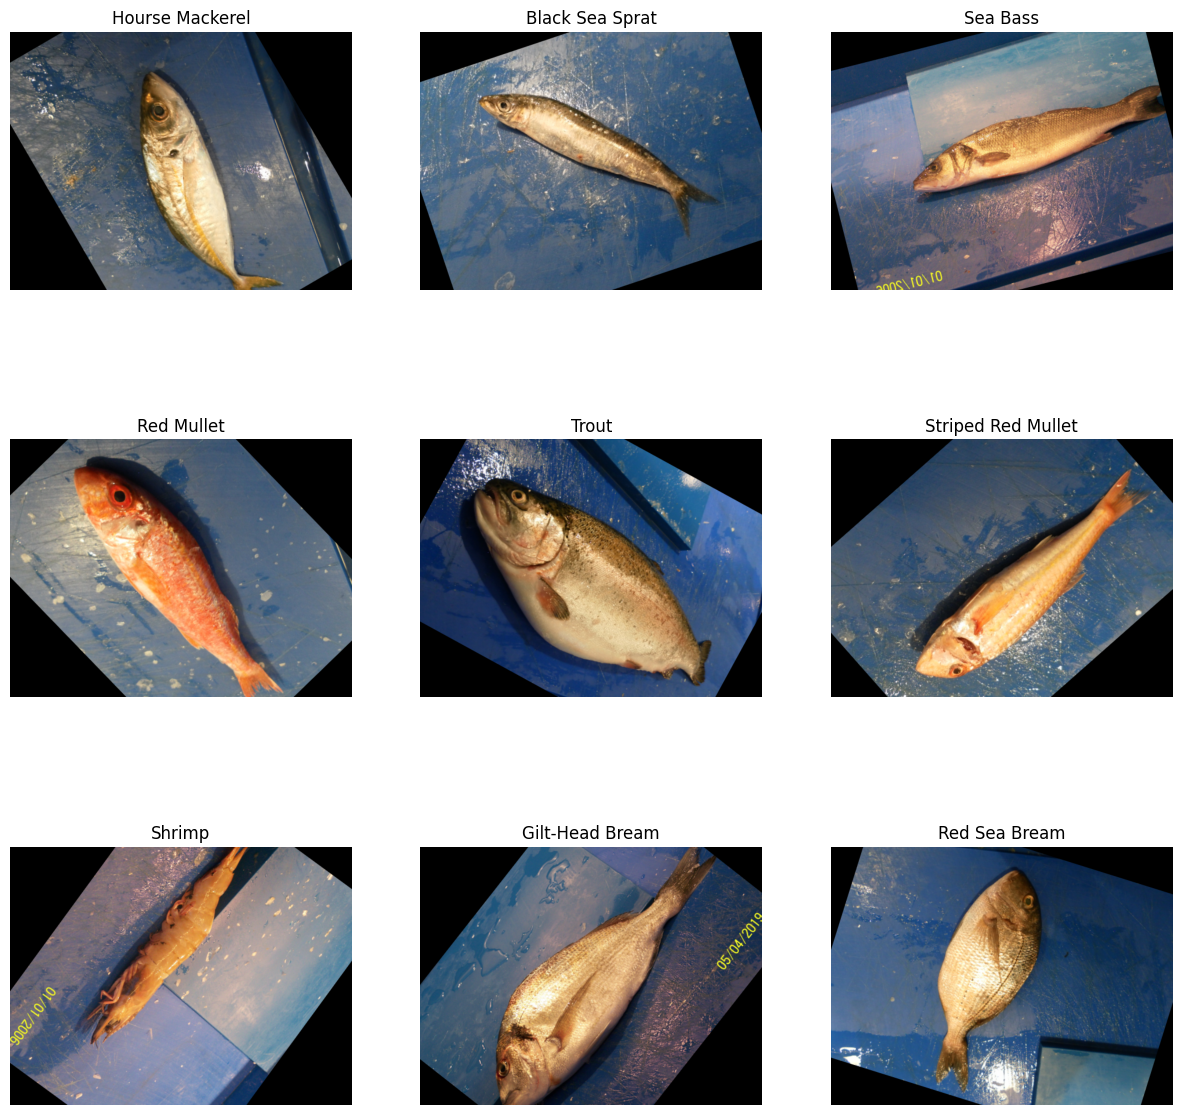

In [9]:

import random  # Rastgele seçimler için gerekli kütüphane

plt.figure(figsize=(15, 15))
# Benzersiz etiketleri döngü ile geç
for idx, unique_label in enumerate(data['label'].unique()):
    plt.subplot(3, 3, idx + 1)  # 3x3'lik bir ızgara oluştur    
    random_image_path = random.choice(data[data['label'] == unique_label]['path'].values)
    plt.imshow(plt.imread(random_image_path))  # Görüntüyü oku ve göster
    plt.title(unique_label)  # Etiketin başlığını ekle
    plt.axis('off')  # Eksenleri gizle


## Sınıf Dağılımı

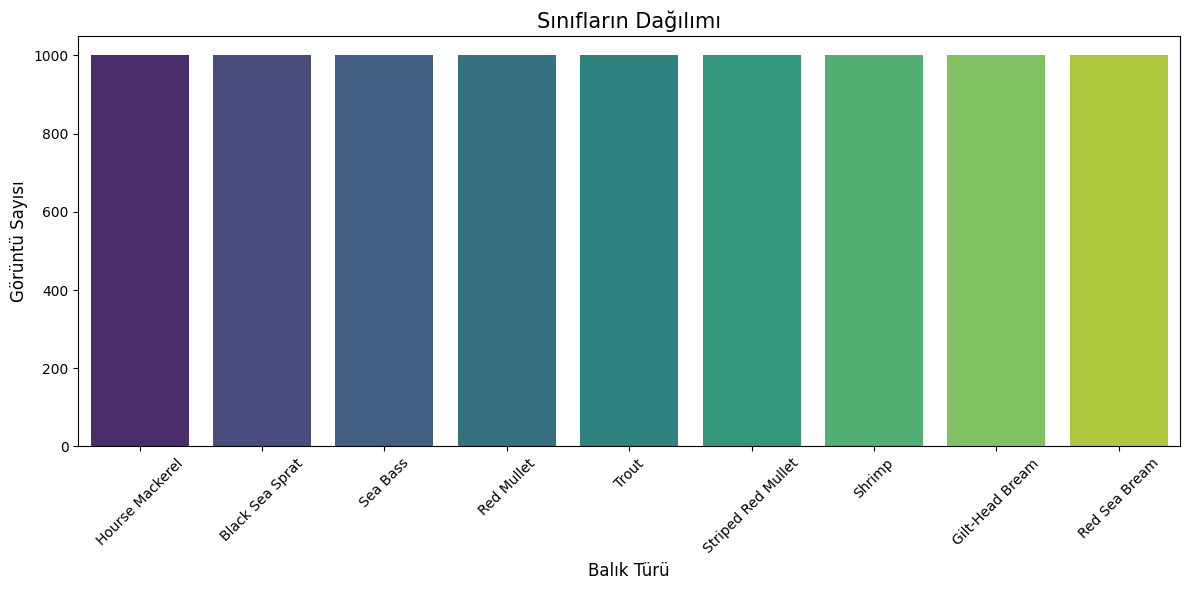

In [10]:
plt.figure(figsize=(12, 6))
sns.countplot(x='label', data=data, palette='viridis')
plt.xticks(rotation=45)
plt.title('Sınıfların Dağılımı', fontsize=15)
plt.xlabel('Balık Türü', fontsize=12)
plt.ylabel('Görüntü Sayısı', fontsize=12)
plt.tight_layout()
plt.show()

## Test ve Eğitim setlerine ayırmak

In [11]:
train_data, test_data = train_test_split(data, test_size=0.2, shuffle=True, random_state=42)

In [12]:
print(train_data.shape)
print(test_data.shape)


(7200, 2)
(1800, 2)


In [13]:
# ImageDataGenerator ile veri artırma ve ön işleme ayarları
train_generator = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.2)
test_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

# Eğitim verilerini yükleme
train_images = train_generator.flow_from_dataframe(
    dataframe=train_data,         # Eğitim verilerini içeren dataframe
    x_col='path',                # Görüntü dosya yollarını içeren sütun
    y_col='label',               # Görüntü etiketlerini içeren sütun
    target_size=(224, 224),      # Görüntü boyutu
    color_mode='rgb',            # Renk modu (RGB)
    class_mode='categorical',    # Çok sınıflı etiketleme
    batch_size=32,               # Batch boyutu
    shuffle=True,                # Verileri karıştır
    seed=42,                     # Tekrar edilebilirlik için rastgelelik tohum değeri
    subset='training'            # Eğitim alt kümesi
)

# Doğrulama verilerini yükleme
val_images = train_generator.flow_from_dataframe(
    dataframe=train_data,         
    x_col='path',                
    y_col='label',               
    target_size=(224, 224),      
    color_mode='rgb',            
    class_mode='categorical',    
    batch_size=32,               
    shuffle=True,                
    seed=42,                     
    subset='validation'           # Doğrulama alt kümesi
)

# Test verilerini yükleme
test_images = test_generator.flow_from_dataframe(
    dataframe=test_data,         
    x_col='path',                
    y_col='label',               
    target_size=(224, 224),      
    color_mode='rgb',            
    class_mode='categorical',    
    batch_size=32,               
    shuffle=False                 # Test verilerini karıştırma
)


Found 5760 validated image filenames belonging to 9 classes.
Found 1440 validated image filenames belonging to 9 classes.
Found 1800 validated image filenames belonging to 9 classes.


In [14]:
# Eğitim sınıf indekslerini listele
print("Eğitim Sınıf İndeksleri:")
for class_name, class_index in train_images.class_indices.items():
    print(f"Sınıf: {class_name}, İndeks: {class_index}")

# Doğrulama sınıf indekslerini listele
print("Doğrulama Sınıf İndeksleri:")
for class_name, class_index in val_images.class_indices.items():
    print(f"Sınıf: {class_name}, İndeks: {class_index}")

# Test sınıf indekslerini listele
print("Test Sınıf İndeksleri:")
for class_name, class_index in test_images.class_indices.items():
    print(f"Sınıf: {class_name}, İndeks: {class_index}")


Eğitim Sınıf İndeksleri:
Sınıf: Black Sea Sprat, İndeks: 0
Sınıf: Gilt-Head Bream, İndeks: 1
Sınıf: Hourse Mackerel, İndeks: 2
Sınıf: Red Mullet, İndeks: 3
Sınıf: Red Sea Bream, İndeks: 4
Sınıf: Sea Bass, İndeks: 5
Sınıf: Shrimp, İndeks: 6
Sınıf: Striped Red Mullet, İndeks: 7
Sınıf: Trout, İndeks: 8
Doğrulama Sınıf İndeksleri:
Sınıf: Black Sea Sprat, İndeks: 0
Sınıf: Gilt-Head Bream, İndeks: 1
Sınıf: Hourse Mackerel, İndeks: 2
Sınıf: Red Mullet, İndeks: 3
Sınıf: Red Sea Bream, İndeks: 4
Sınıf: Sea Bass, İndeks: 5
Sınıf: Shrimp, İndeks: 6
Sınıf: Striped Red Mullet, İndeks: 7
Sınıf: Trout, İndeks: 8
Test Sınıf İndeksleri:
Sınıf: Black Sea Sprat, İndeks: 0
Sınıf: Gilt-Head Bream, İndeks: 1
Sınıf: Hourse Mackerel, İndeks: 2
Sınıf: Red Mullet, İndeks: 3
Sınıf: Red Sea Bream, İndeks: 4
Sınıf: Sea Bass, İndeks: 5
Sınıf: Shrimp, İndeks: 6
Sınıf: Striped Red Mullet, İndeks: 7
Sınıf: Trout, İndeks: 8


## Görüntüleri Gösterme ve Çizme (Etiketleriyle)

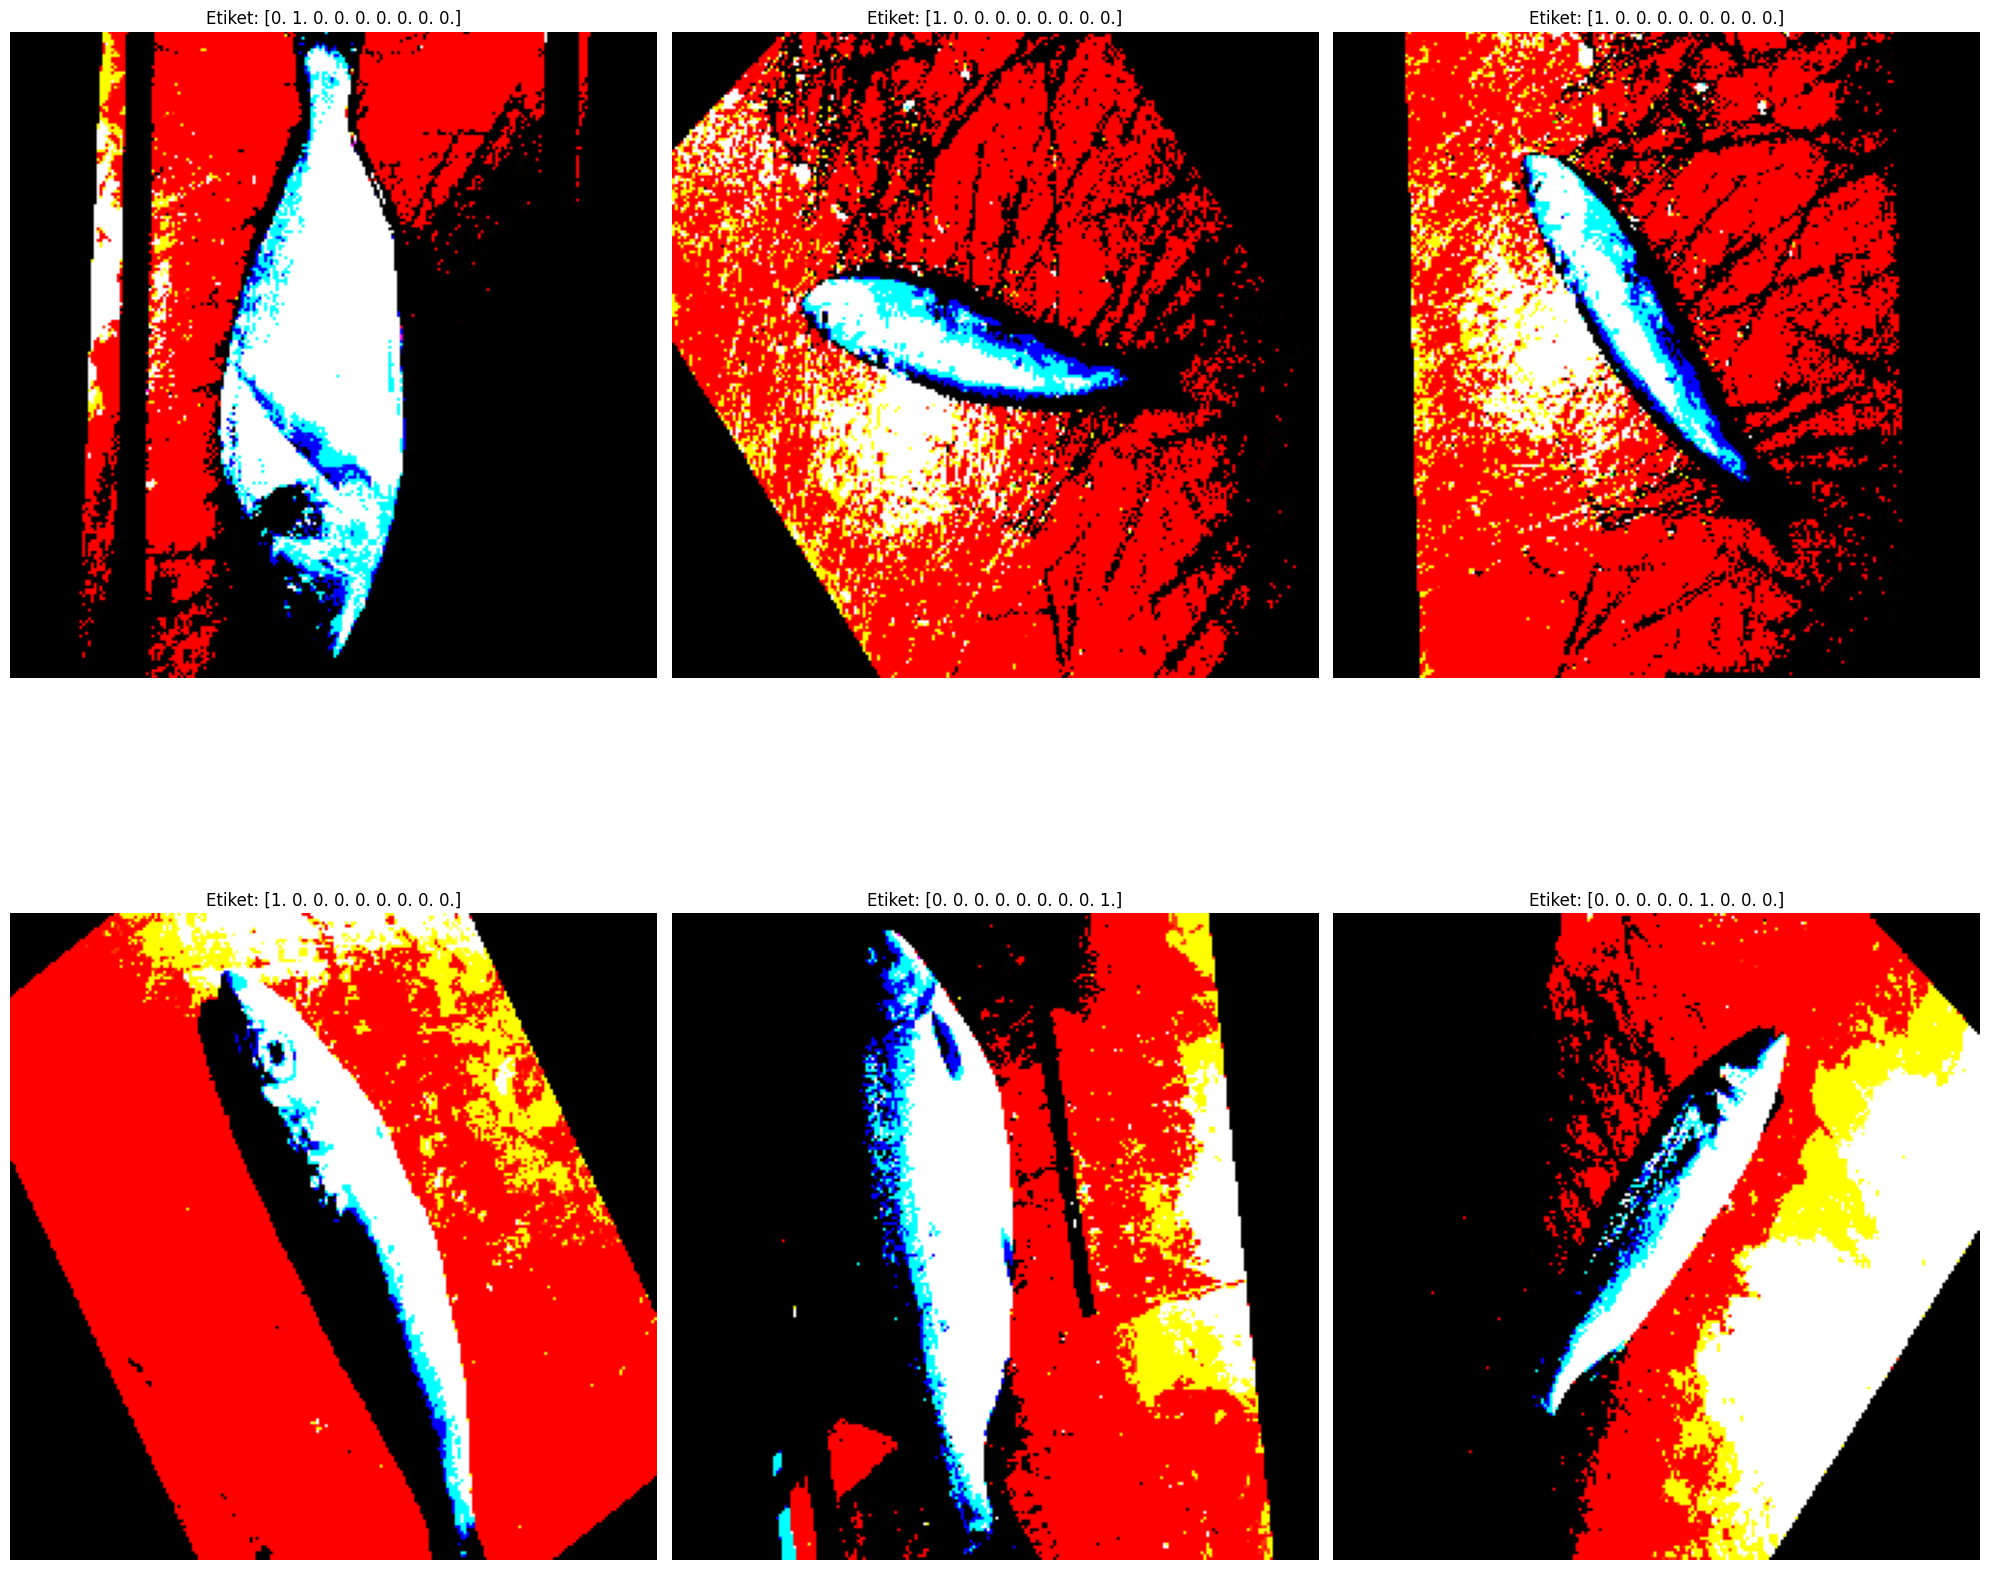

In [15]:
import matplotlib.pyplot as plt

# Grafik alanı oluşturma
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 20))
axes = axes.flatten()  # Eksenleri düzleştir

# Görüntüleri gösterme
for i, (images, labels) in enumerate(test_images):
    if i >= 6:  # İlk 6 görüntü ile sınırlı
        break
    
    # Görüntü ve etiket alınması
    image = images[0]
    label = labels[0] if isinstance(labels, (list, np.ndarray)) else labels

    # Görüntüyü çizme
    axes[i].imshow(image)
    axes[i].set_title(f"Etiket: {label}")  # Başlık olarak etiketi ayarlama
    axes[i].axis('off')  # Eksenleri kapatma

plt.tight_layout()  # Grafikler arasındaki boşlukları ayarla
plt.show()  # Grafik göster


In [16]:
test_images[0][0].shape

(32, 224, 224, 3)

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.optimizers import Adam

# Modeli oluştur
model = Sequential([
    Input(shape=(224, 224, 3)),  # Giriş boyutunu belirtin
    Flatten(),  # Özellik haritalarını düzleştirir
    Dense(512, activation='relu'),  # Tam bağlantılı katman
    Dense(128, activation='relu'),  # Tam bağlantılı katman
    Dense(9, activation='softmax')  # Sınıflandırma için 9 sınıflı çıkış
])

# Modeli derle
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

print(model.summary())


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 150528)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    77,070,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 77,137,673 (294.26 MB)

 Trainable params: 77,137,673 (294.26 MB)

 Non-trainable params: 0 (0.00 B)

None


In [18]:
from tensorflow.keras.callbacks import EarlyStopping

# Erken durdurma callback'i
early_stop = EarlyStopping(monitor='val_loss', patience=2)

# Modeli eğit
history = model.fit(train_images, epochs=15,
                    validation_data=val_images,
                    callbacks=[early_stop])


Epoch 1/15
180/180 ━━━━━━━━━━━━━━━━━━━━ 219s 1s/step - accuracy: 0.3678 - loss: 2413.5503 - val_accuracy: 0.6542 - val_loss: 253.4763
Epoch 2/15
180/180 ━━━━━━━━━━━━━━━━━━━━ 195s 1s/step - accuracy: 0.6900 - loss: 193.3305 - val_accuracy: 0.7458 - val_loss: 130.9727
Epoch 3/15
180/180 ━━━━━━━━━━━━━━━━━━━━ 237s 1s/step - accuracy: 0.7886 - loss: 92.3089 - val_accuracy: 0.7896 - val_loss: 84.2166
Epoch 4/15
180/180 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/step - accuracy: 0.8487 - loss: 50.7978 - val_accuracy: 0.7764 - val_loss: 82.1855
Epoch 5/15
180/180 ━━━━━━━━━━━━━━━━━━━━ 199s 1s/step - accuracy: 0.8792 - loss: 35.3292 - val_accuracy: 0.8090 - val_loss: 67.0164
Epoch 6/15
180/180 ━━━━━━━━━━━━━━━━━━━━ 200s 1s/step - accuracy: 0.8743 - loss: 34.9289 - val_accuracy: 0.8424 - val_loss: 46.5569
Epoch 7/15
180/180 ━━━━━━━━━━━━━━━━━━━━ 200s 1s/step - accuracy: 0.9062 - loss: 22.9060 - val_accuracy: 0.8417 - val_loss: 58.9481
Epoch 8/15
180/180 ━━━━━━━━━━━━━━━━━━━━ 200s 1s/step - accuracy: 0.8982 - loss

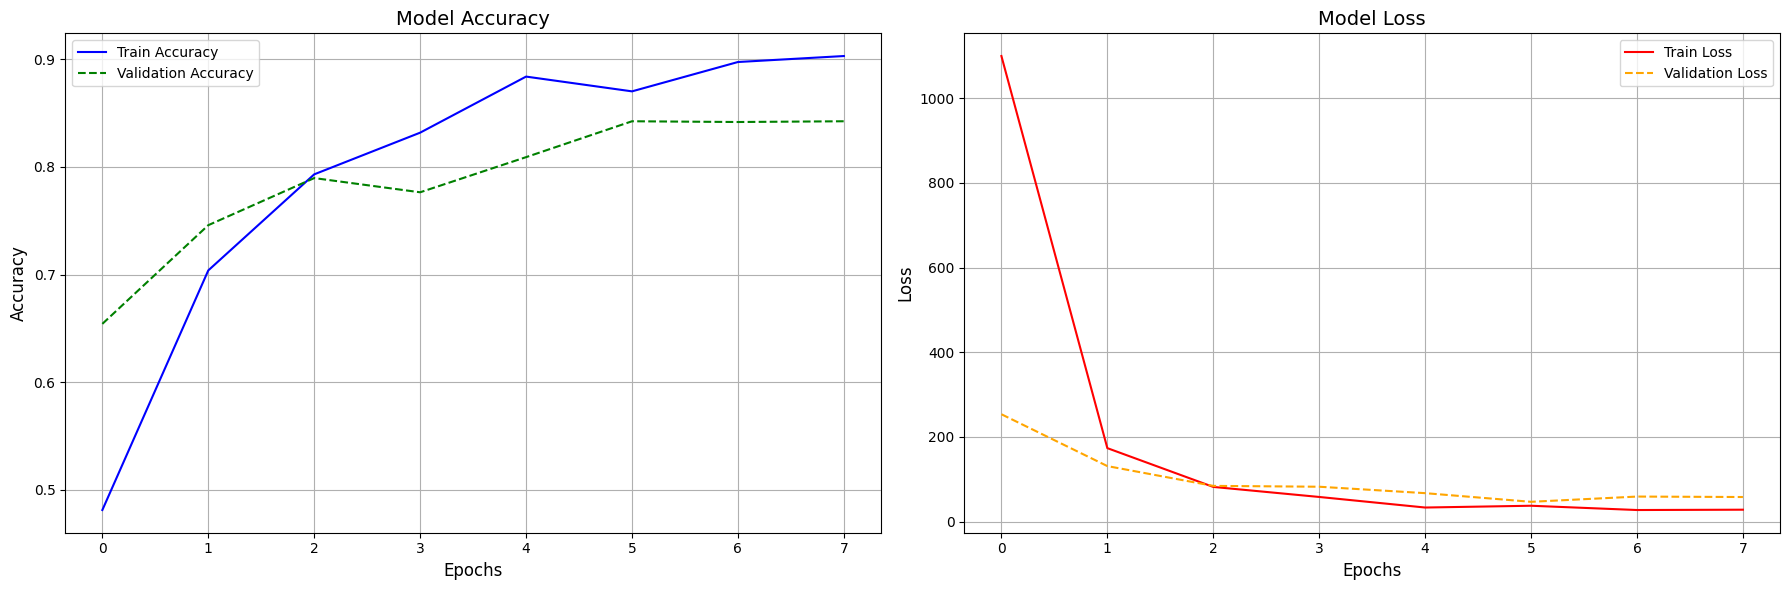

In [19]:


# Eğitim geçmişini görselleştirme
result = pd.DataFrame(history.history)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
ax = ax.flatten()

# Accuracy grafiği
ax[0].plot(result['accuracy'], label='Train Accuracy', color='b', linestyle='-')
ax[0].plot(result['val_accuracy'], label='Validation Accuracy', color='g', linestyle='--')
ax[0].set_title("Model Accuracy", fontsize=14)
ax[0].set_xlabel("Epochs", fontsize=12)
ax[0].set_ylabel("Accuracy", fontsize=12)
ax[0].legend(loc="best")
ax[0].grid(True)

# Loss grafiği
ax[1].plot(result['loss'], label='Train Loss', color='r', linestyle='-')
ax[1].plot(result['val_loss'], label='Validation Loss', color='orange', linestyle='--')
ax[1].set_title("Model Loss", fontsize=14)
ax[1].set_xlabel("Epochs", fontsize=12)
ax[1].set_ylabel("Loss", fontsize=12)
ax[1].legend(loc="best")
ax[1].grid(True)

plt.tight_layout()
plt.show()


In [20]:
import numpy as np
from sklearn.metrics import accuracy_score

# Tahmin yap ve sonuçları görselleştir
pred = model.predict(test_images)
pred = np.argmax(pred, axis=1)

# Etiketleri gerçek sınıflarla eşleştir
predict_data = test_data.copy()
labels = {v: k for k, v in test_images.class_indices.items()}
predict_data['pred'] = pred
predict_data['pred'] = predict_data['pred'].apply(lambda x: labels[x])

predict_data = predict_data.reset_index(drop=True)
print(predict_data.head(10))


57/57 ━━━━━━━━━━━━━━━━━━━━ 32s 557ms/step
                                                path               label  \
0  /kaggle/input/a-large-scale-fish-dataset/Fish_...     Gilt-Head Bream   
1  /kaggle/input/a-large-scale-fish-dataset/Fish_...     Black Sea Sprat   
2  /kaggle/input/a-large-scale-fish-dataset/Fish_...     Hourse Mackerel   
3  /kaggle/input/a-large-scale-fish-dataset/Fish_...               Trout   
4  /kaggle/input/a-large-scale-fish-dataset/Fish_...       Red Sea Bream   
5  /kaggle/input/a-large-scale-fish-dataset/Fish_...       Red Sea Bream   
6  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Striped Red Mullet   
7  /kaggle/input/a-large-scale-fish-dataset/Fish_...       Red Sea Bream   
8  /kaggle/input/a-large-scale-fish-dataset/Fish_...          Red Mullet   
9  /kaggle/input/a-large-scale-fish-dataset/Fish_...               Trout   

                 pred  
0     Gilt-Head Bream  
1     Black Sea Sprat  
2     Gilt-Head Bream  
3               Trout  
4

                                                 path               label  \
2   /kaggle/input/a-large-scale-fish-dataset/Fish_...     Hourse Mackerel   
4   /kaggle/input/a-large-scale-fish-dataset/Fish_...       Red Sea Bream   
7   /kaggle/input/a-large-scale-fish-dataset/Fish_...       Red Sea Bream   
10  /kaggle/input/a-large-scale-fish-dataset/Fish_...          Red Mullet   
11  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Striped Red Mullet   

               pred  
2   Gilt-Head Bream  
4             Trout  
7             Trout  
10  Hourse Mackerel  
11  Gilt-Head Bream  


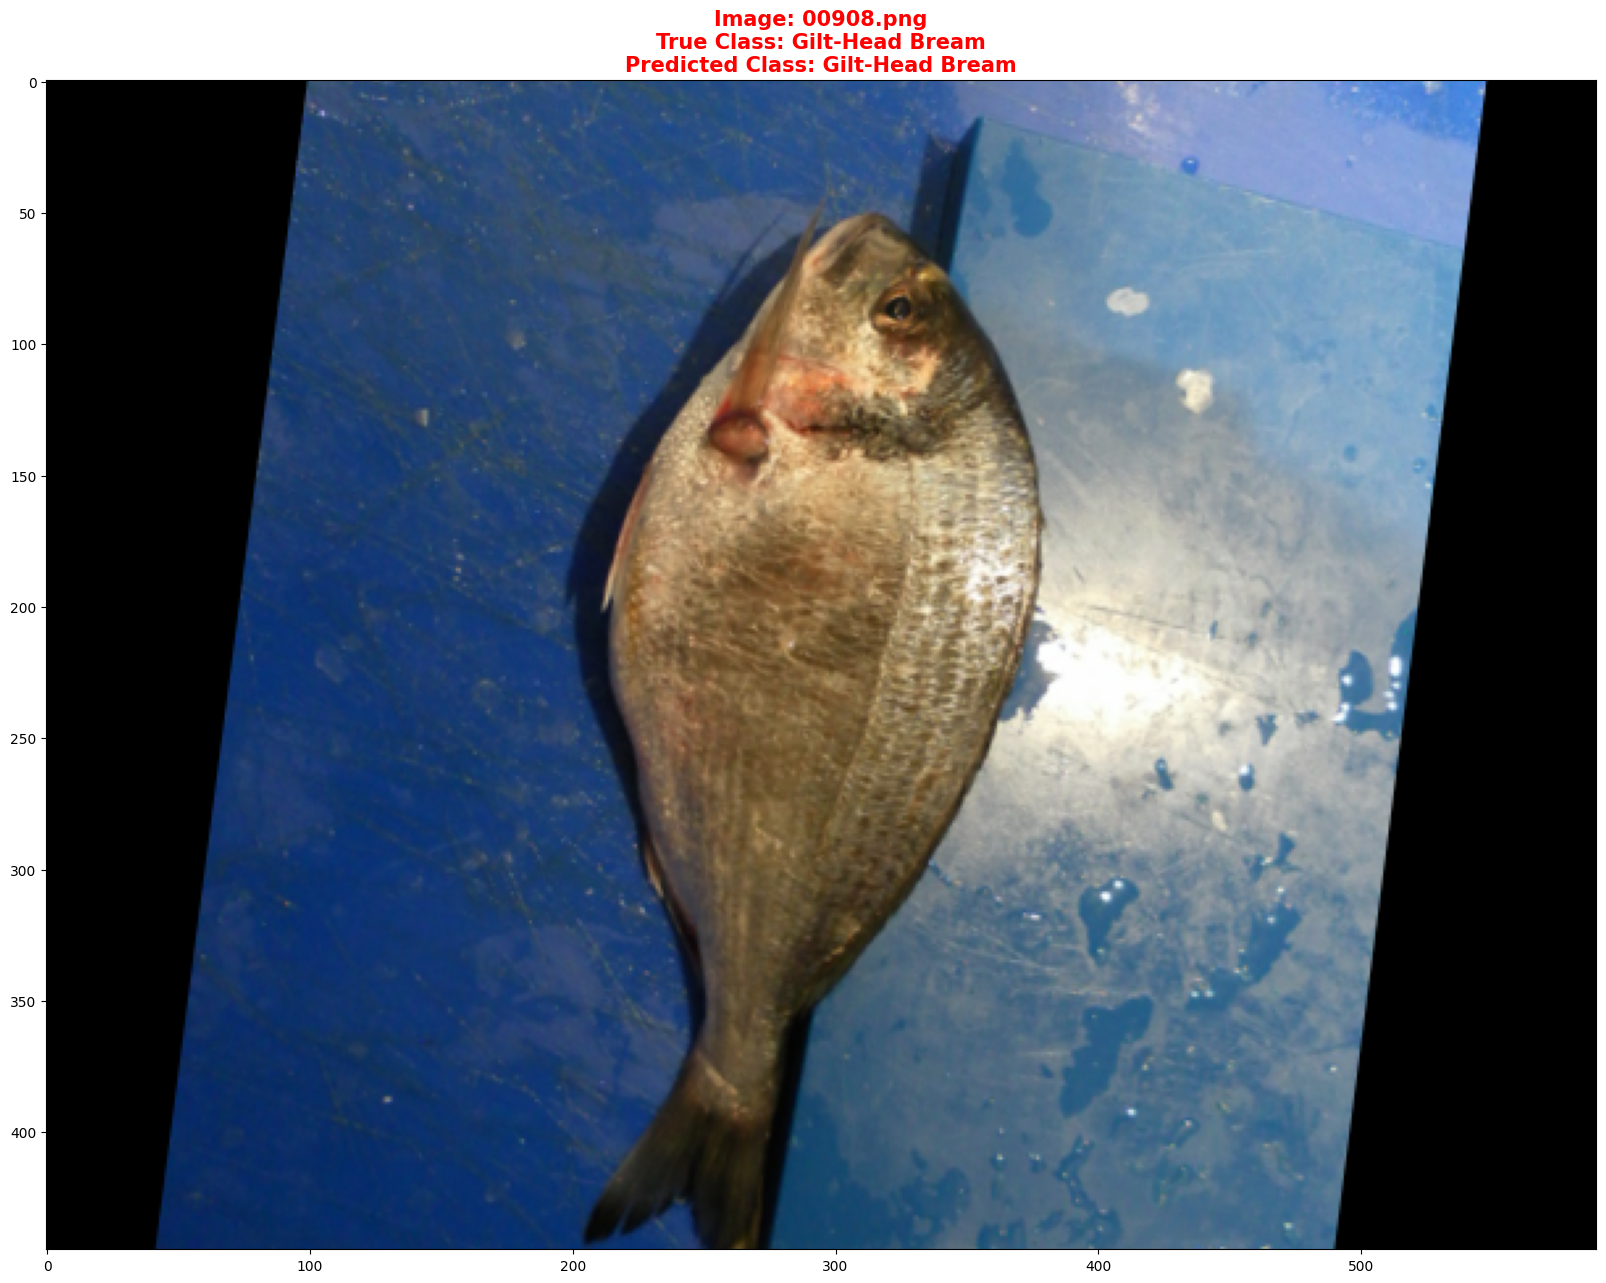

In [21]:
import matplotlib.pyplot as plt

# Yanlış tahmin edilenleri göster
print(predict_data[predict_data['label'] != predict_data['pred']].head())

# Örnek bir yanlış tahmin görselini göster
plt.figure(figsize=(20, 20))
plt.imshow(plt.imread(predict_data.path[26]))
title1 = predict_data.path[26].split('/')[-2]
title2 = predict_data.path[26].split('/')[-1]
title3 = predict_data.pred[26]
plt.title(f'Image: {title2}\nTrue Class: {title1}\nPredicted Class: {title3}', color='r', weight='bold', fontsize=15)
plt.show()


Accuracy Score: 0.8266666666666667


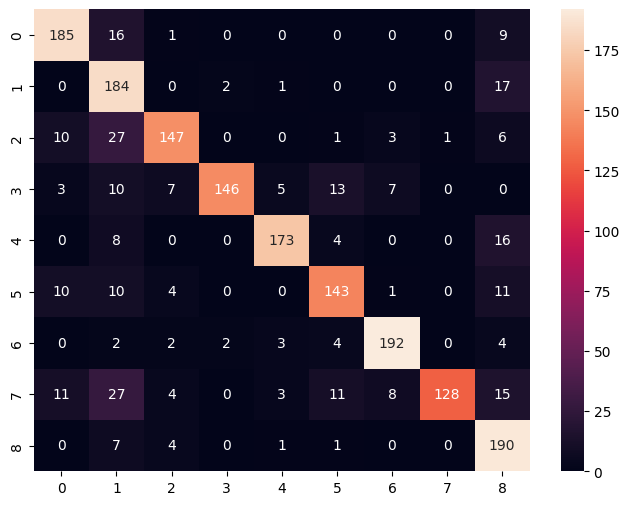

In [22]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Doğruluk skorunu yazdır
print(f"Accuracy Score: {accuracy_score(predict_data['label'], predict_data['pred'])}")

# Confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(predict_data['label'], predict_data['pred']), annot=True, fmt='d')
plt.show()


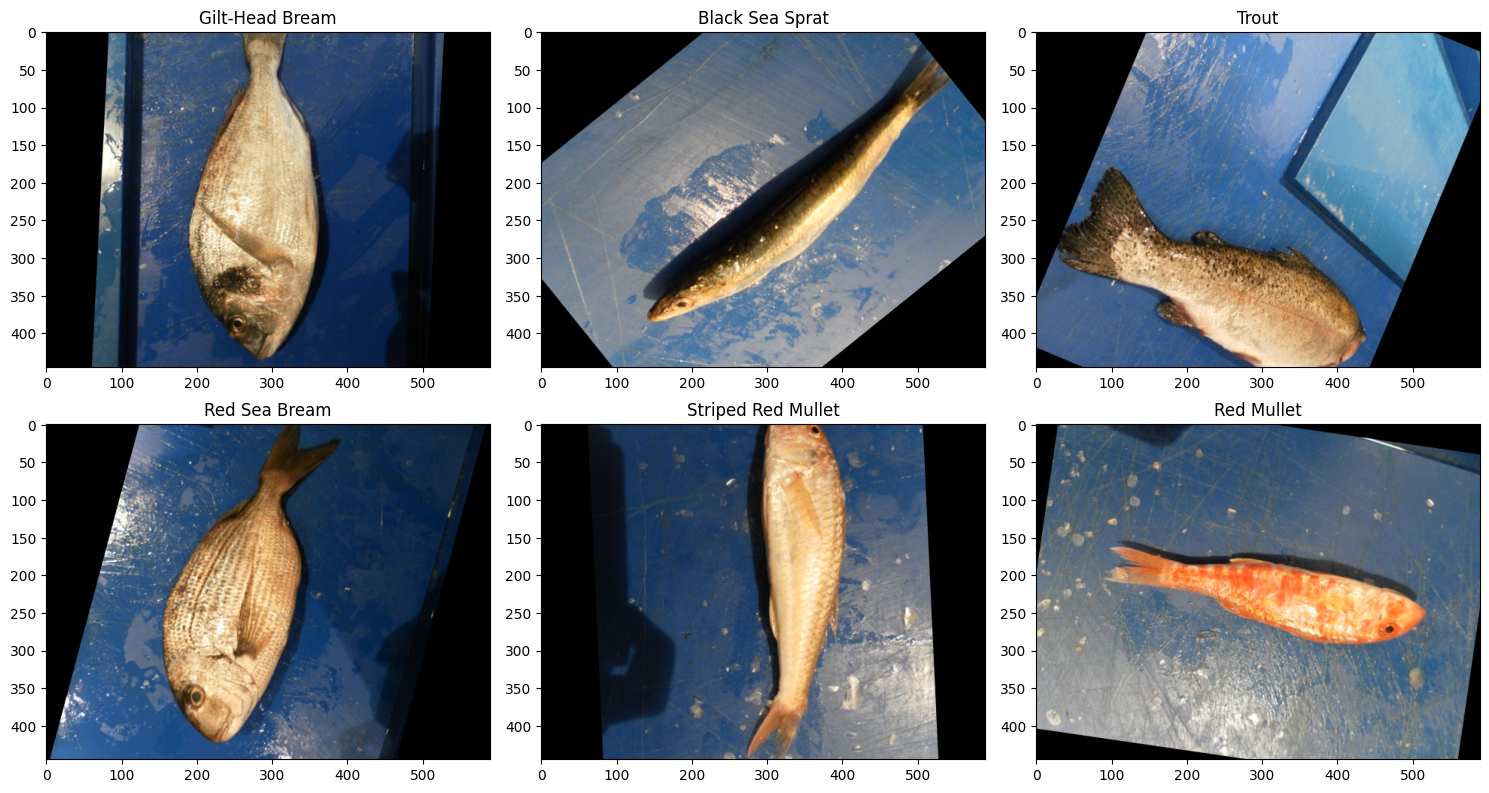

In [23]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))
ax = ax.flatten()
imlist = predict_data[predict_data['label'] == predict_data['pred']].head(6).reset_index()

for i in range(6):
    ax[i].imshow(plt.imread(imlist['path'][i]))
    ax[i].set_title(imlist['label'][i])

plt.tight_layout()
plt.show()
